# Первая домашка: Титаник

Импортирую нужные модули, загружаю датасет.

In [34]:
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.metrics import f1_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

titanic = sns.load_dataset("titanic")

## 1. Графики!!1

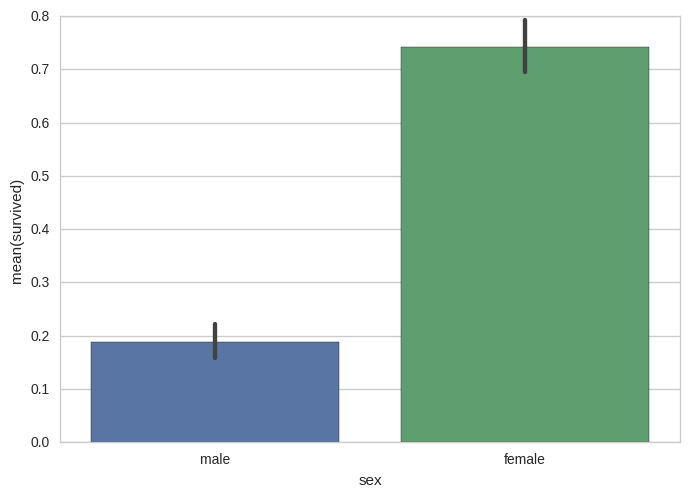

In [35]:
sns.set(style="whitegrid", color_codes=True)
np.random.seed(sum(map(ord, "categorical")))
sns.barplot(x="sex", y="survived", data=titanic)
plt.show()

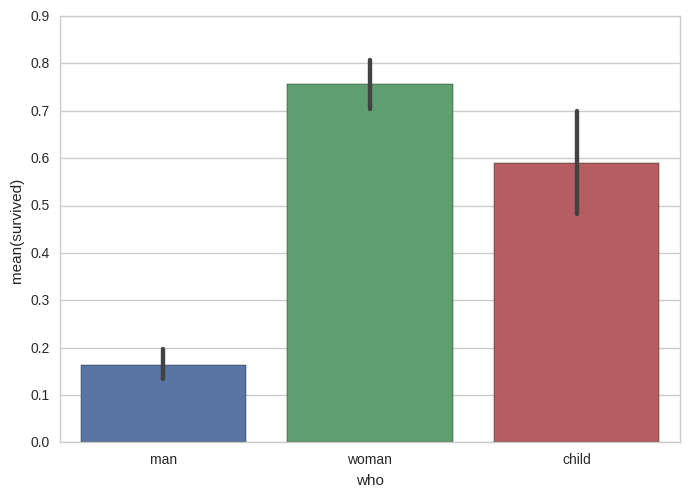

In [42]:
sns.barplot(x="who", y="survived", data=titanic)
plt.show()

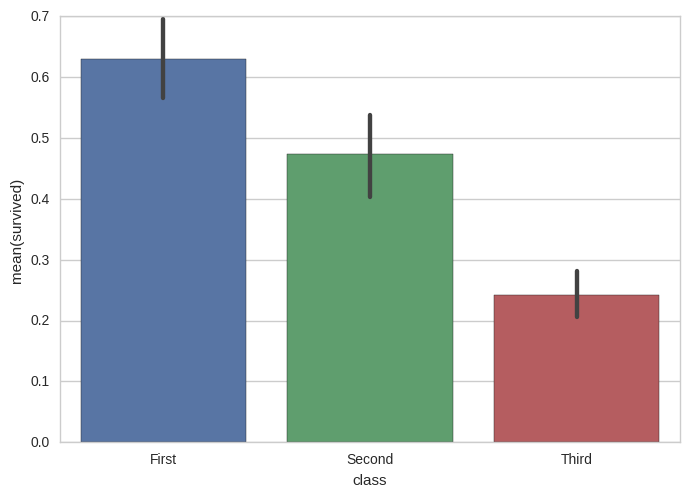

In [23]:
sns.barplot(x="class", y="survived", data=titanic)
plt.show()

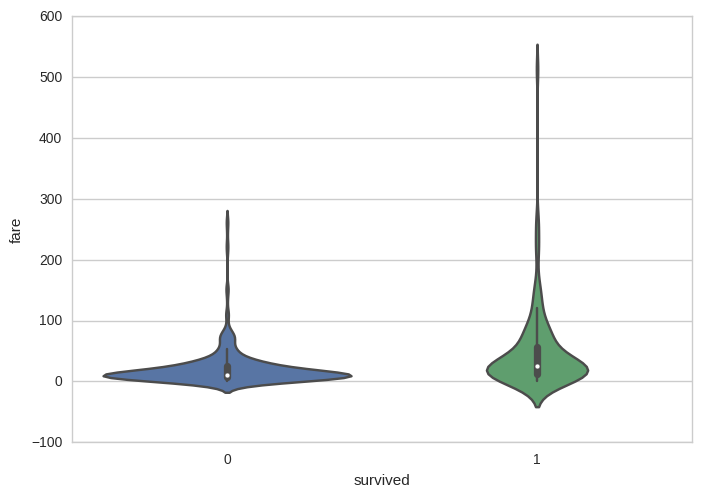

In [41]:
sns.violinplot(x="survived", y="fare", data=titanic)
plt.show()

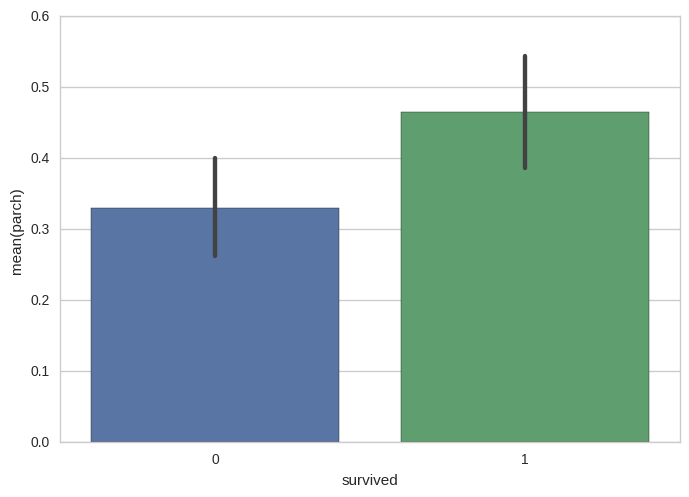

In [35]:
sns.barplot(x="survived", y="parch", data=titanic)
plt.show()

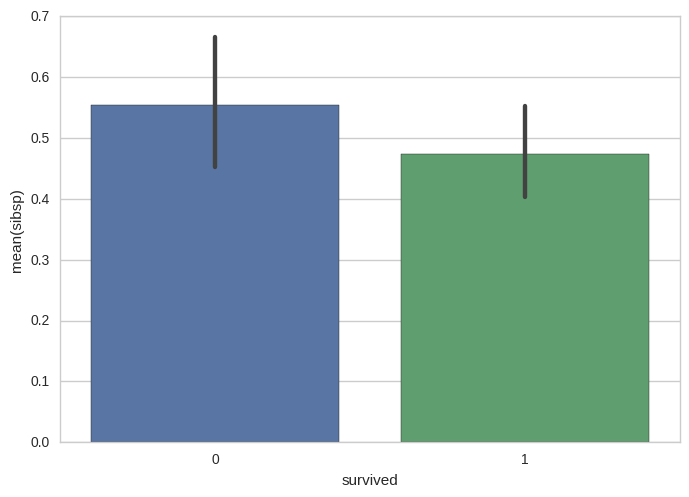

In [47]:
sns.barplot(x="survived", y="sibsp", data=titanic)
plt.show()

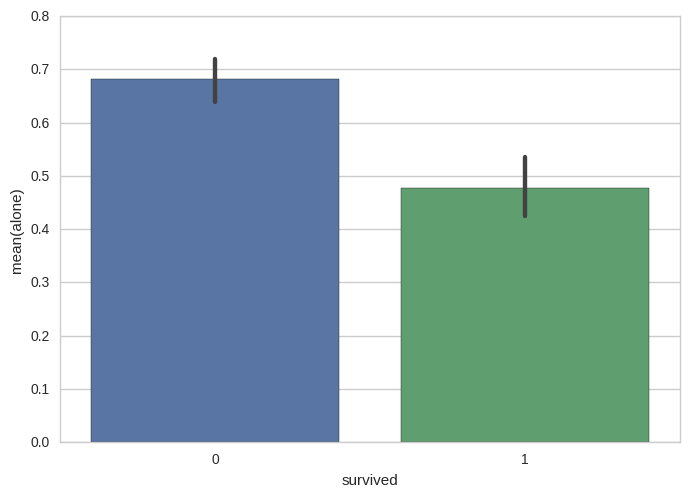

In [46]:
sns.barplot(x="survived", y="alone", data=titanic)
plt.show()

Интерпретация:
* вероятность выжить на титанике, если ты женщина, выше
* у тебя также довольно высока вероятность выжить, если ты ребёнок
* чем выше у тебя класс, тем выше вероятность выжить на титанике
* среди выживших значительно меньше тех, кто платил за билет не очень много; все, кто заплатил за билет больше 300, выжили
* у выживших было в среднем больше родителей на борту
* у невыживших было в среднем больше сиблингов на борту
* среди невыживших было в среднем больше одиноких

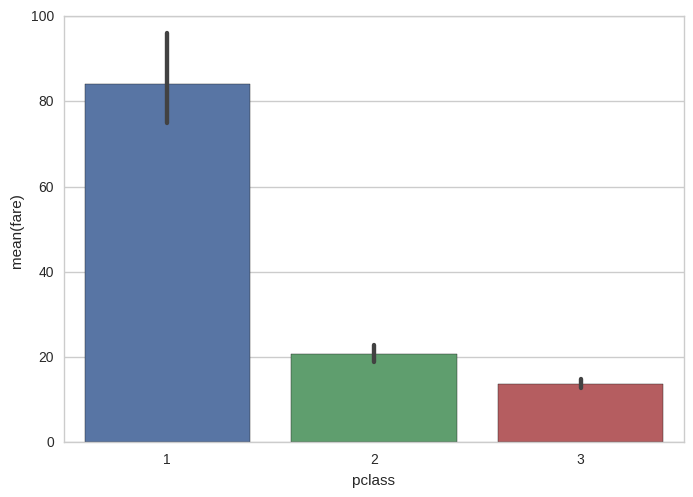

In [29]:
sns.barplot(x="pclass", y="fare", data=titanic)
plt.show()

Интерпретация: билеты дороже всего у пассажиров первого класса, причём с сильным отрывом. Стоимость билетов у пассажиров 2 и 3 класса не сильно различается, но у 2 класса несколько выше, чем у 1. Здесь очень хорошо видно, что переменные pclass и fare не являются независимыми.

## 2. Два предиктора.

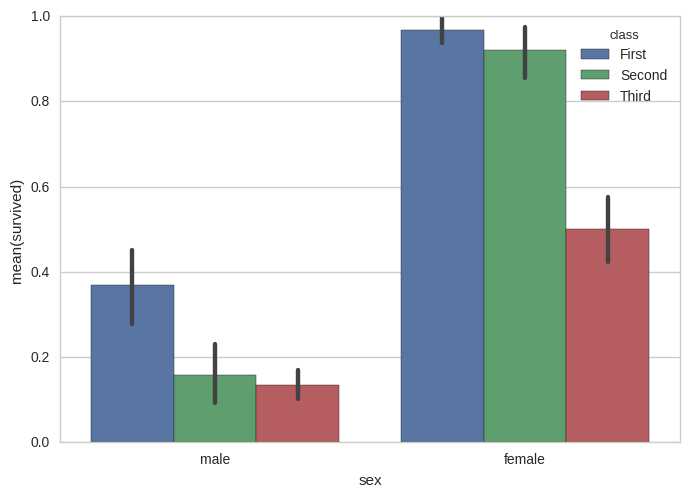

In [18]:
sns.barplot(x="sex", y="survived", hue="class", data=titanic)
plt.show()

Выше всего вероятность выжить, если ты женщина первого или второго класса. Впрочем, даже у женщин 3 классы верорятность выжить выше, чем у мужчин 1 класса.
Меньше всего вероятность выжить, если ты мужчина 2 или 3 класса.

## 3. Чищу данные.

In [ ]:
titanic_y = titanic['survived']
titanic_x = titanic.loc[:, ('pclass', 'sex', 'age', 'alone')]

# заменяю значения NaN на среднее арифметическое
m = titanic_x['age'].mean()
titanic_x['age'] = titanic_x['age'].fillna(value=m)

# заменяю значения переменной sex на логические
sex = titanic_x['sex']
titanic_x['sex'] = pd.get_dummies(sex)['male']

titanic_x.tail()

У меня не получилось найти такой пятый параметр, который имел бы значение, и был бы независимым.

## 4. Деревья решений

Getting baseline

In [143]:
train_x, test_x, train_y, test_y = train_test_split(titanic_x, titanic_y, test_size=0.2)
clf = DecisionTreeClassifier()
clf.fit(np.array(train_x), np.array(train_y))
predict_y = clf.predict(test_x)
print(classification_report(test_y, predict_y))

             precision    recall  f1-score   support

          0       0.75      0.88      0.81       108
          1       0.75      0.56      0.65        71

avg / total       0.75      0.75      0.75       179



### Варьирование параметров

По дефолту min_samples_leaf был равен 1, что могло привести к оверфиттингу. Я варьирую их количество от 1 до 10. С этой же целью (чтобы избежать оверфиттинга), я пробую разные max_depth.

In [144]:
from sklearn import svm, datasets
from sklearn.model_selection import GridSearchCV

parameters = {'min_samples_leaf':range(1, 21), 'max_depth':range(1, 10)}
grid = GridSearchCV(clf, parameters)
grid.fit(train_x, train_y)

GridSearchCV(cv=None, error_score='raise',
       estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            presort=False, random_state=None, splitter='best'),
       fit_params={}, iid=True, n_jobs=1,
       param_grid={'max_depth': range(1, 10), 'min_samples_leaf': range(1, 21)},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring=None, verbose=0)

In [145]:
print(grid.best_score_)

0.828651685393


In [146]:
grid.best_params_

{'max_depth': 8, 'min_samples_leaf': 4}

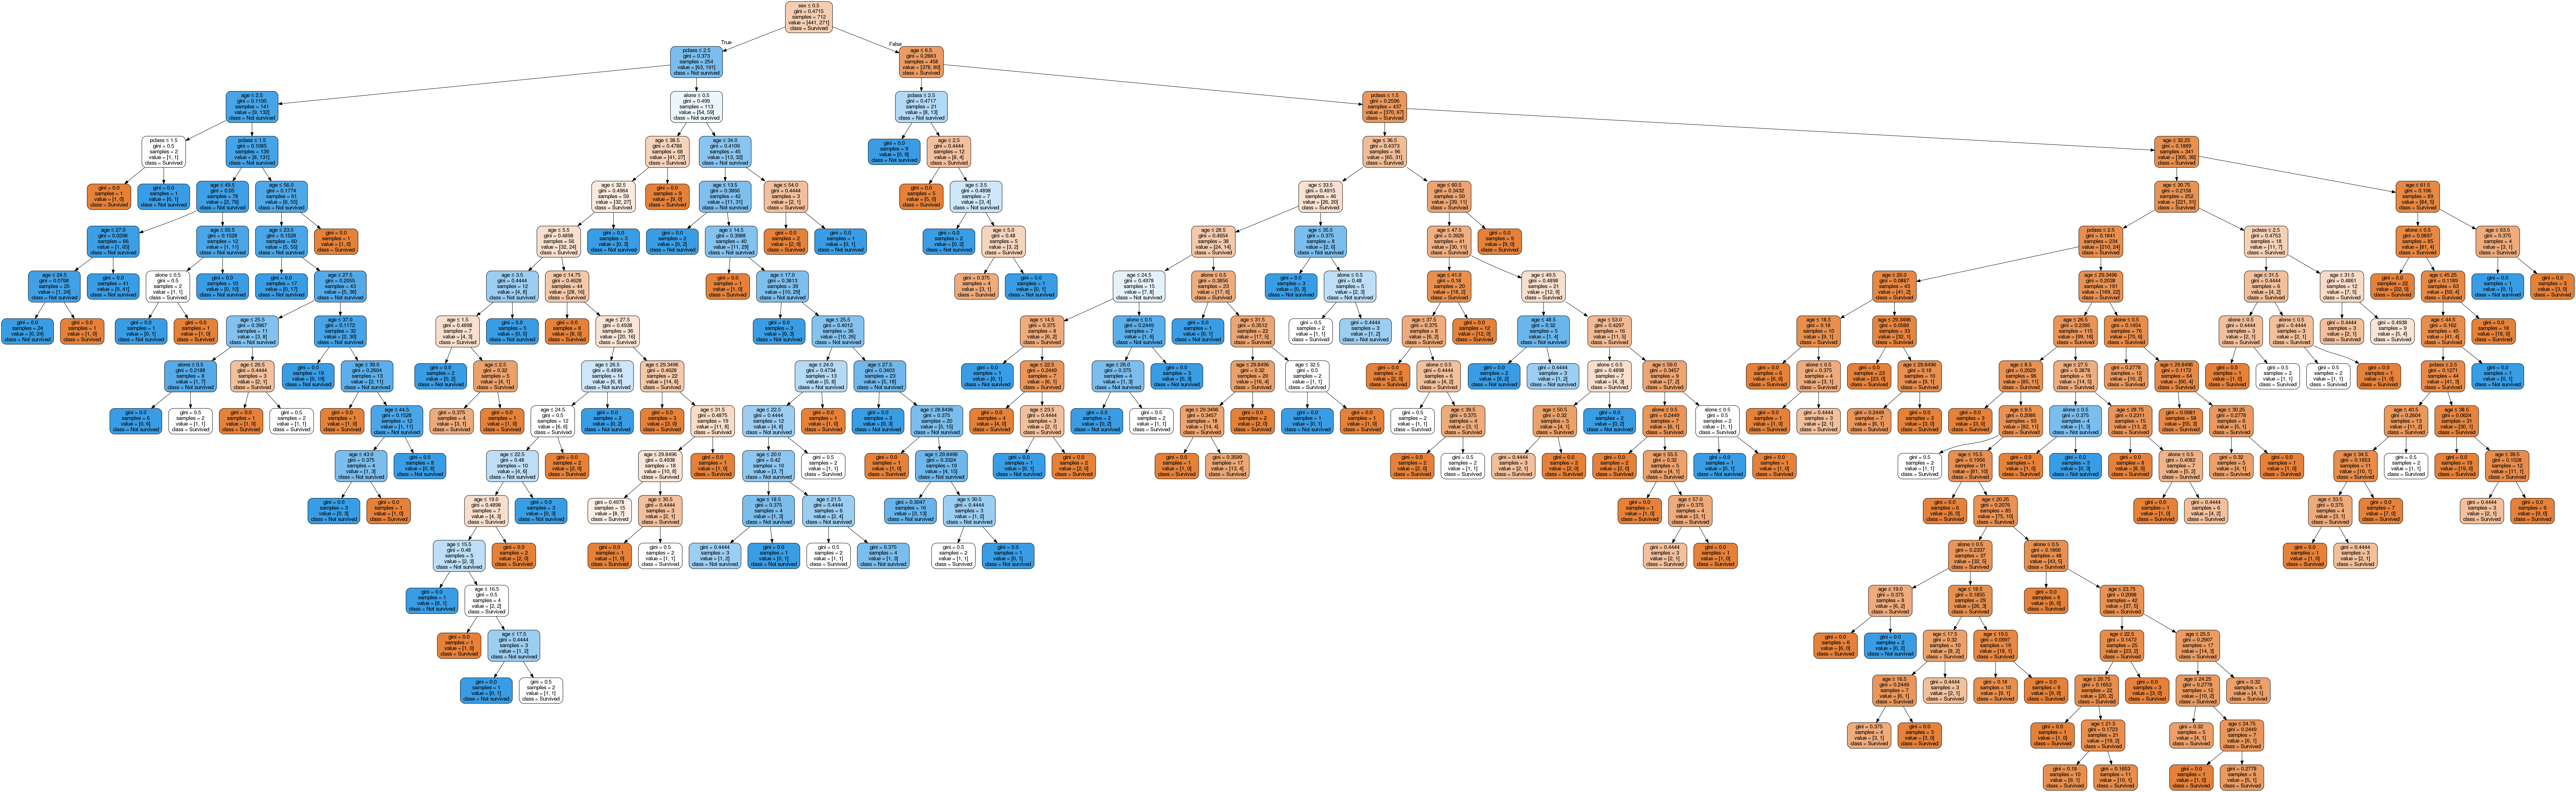

In [147]:
from IPython.display import Image
from sklearn.tree import export_graphviz
import pydotplus

best = grid.best_estimator_
dot_data = tree.export_graphviz(clf, out_file=None,
                                feature_names=titanic_x.columns,  
                                class_names=['Survived', 'Not survived'],  
                                filled=True, rounded=True,  
                                special_characters=True)  
graph = pydotplus.graph_from_dot_data(dot_data)  
Image(graph.create_png())  

Ограничив возможную глубину дерева, я, как мне кажется, избежала оверфиттинга. (Или почти).

In [148]:
# проверяю, как лучшая модель работает на тестовой выборке

predict_y = grid.best_estimator_.predict(test_x)
print(classification_report(test_y, predict_y))

             precision    recall  f1-score   support

          0       0.77      0.88      0.82       108
          1       0.76      0.59      0.67        71

avg / total       0.77      0.77      0.76       179



## 5. Рандомный лес

In [ ]:
model = RandomForestClassifier(n_estimators = 100)